In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [2]:
akarsu_df = pd.read_csv('../RelevantData/akarsu_relevant.csv', parse_dates = ['Tarih'], index_col = 'Tarih')

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
akarsu_cols = ['Fekal_Koliform', 'Toplam_Koliform', 'Toplam_Fosfor', 'Toplam_Kjeldahl_Azotu', 'Kimyasal_Oksijen_İhtiyacı', 'Nitrat_Azotu', 'Çözünmüş_Oksijen']

In [5]:
akarsu_df

,Numune_Adı,Fekal_Koliform,Toplam_Koliform,Toplam_Fosfor,Toplam_Kjeldahl_Azotu,Toplam_Pestisit,Kimyasal_Oksijen_İhtiyacı,Nitrat_Azotu,Çözünmüş_Oksijen
Tarih,,,,,,,,,
05/07/02 00:00:00,BLYS1,1900.00000,2100.00000,0.10000,NaN,NaN,4.99995,0.69000,7.34000
05/07/02 00:00:00,BLYS2,1800.00000,2200.00000,0.05700,NaN,NaN,5.57000,0.42700,6.59000
05/07/02 00:00:00,BLYS3,1600.00000,2200.00000,0.00700,NaN,NaN,6.60000,0.47800,10.93000
05/07/03 00:00:00,BLYS4,1200.00000,1600.00000,4.50000,NaN,NaN,35.40000,0.08700,1.54000
05/07/03 00:00:00,BLYS5,1600.00000,2000.00000,1.42000,NaN,NaN,28.20000,0.04800,1.96000
...,...,...,...,...,...,...,...,...,...
2020-12-23 00:00:00,A50,150.00000,16000.00000,0.30200,0.50000,NaN,9.99990,0.47100,104.90000
2020-08-17 00:00:00,A51,1400.00000,120000.00000,0.09500,0.50000,NaN,20.17000,0.11200,81.00000
2020-09-23 00:00:00,A51,2500.00000,200000.00000,0.05230,1.45000,NaN,22.60000,0.12300,89.60000


In [6]:
# Removing Toplam_Pestisit column because 90% of it is empty.
akarsu_df = akarsu_df.drop(columns = 'Toplam_Pestisit')
# Dropping missing features
akarsu_df = akarsu_df.dropna()
# Manually correcting dates of two samples
akarsu_df.index = akarsu_df.index.str.replace("28:.12.2016", "28.12.2016", regex = True)
akarsu_df.index = akarsu_df.index.str.replace("22.009.2016", "22.09.2016", regex = True)

In [7]:
# Scale features
akarsu_scaled = akarsu_df.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for i in akarsu_cols:
    akarsu_scaled[[i]] = scaler.fit_transform(akarsu_df[[i]])

akarsu_scaled.index = pd.to_datetime(akarsu_scaled.index, yearfirst = True)
akarsu_df.index = pd.to_datetime(akarsu_df.index, yearfirst = True)
df = akarsu_scaled
#df.index = pd.DatetimeIndex(df.index).to_period('M')
#df = akarsu_df

In [8]:
df['chunkID'] = df.groupby('Numune_Adı').ngroup()
df = df.drop(labels = ['Numune_Adı'], axis = 1)
df = df.sort_values(by=['chunkID', 'Tarih'])

In [9]:
recurrence = pd.DataFrame(df['chunkID'].value_counts())
recurrence

,chunkID
37,91
73,91
36,91
30,91
38,91
...,...
67,5
66,5
65,5
70,3


In [10]:
df

,Fekal_Koliform,Toplam_Koliform,Toplam_Fosfor,Toplam_Kjeldahl_Azotu,Kimyasal_Oksijen_İhtiyacı,Nitrat_Azotu,Çözünmüş_Oksijen,chunkID
Tarih,,,,,,,,
2011-02-26,0.00003,0.00002,0.00132,0.00394,0.01418,0.00018,0.25952,0
2011-03-10,0.00004,0.00002,0.00303,0.00394,0.01064,0.00121,0.23208,0
2011-04-07,0.00002,0.00001,0.00132,0.00482,0.00355,0.00051,0.22813,0
2011-04-07,0.00002,0.00001,0.00132,0.00482,0.00355,0.00051,0.22813,0
2011-05-06,0.00002,0.00001,0.00250,0.00394,0.00851,0.00096,0.00293,0
...,...,...,...,...,...,...,...,...
2018-09-20,0.00013,0.00018,0.01303,0.00079,0.01418,0.00006,0.02247,121
2018-10-05,0.00006,0.00008,0.00211,0.00079,0.01525,0.00006,0.02620,121
2020-08-31,0.00000,0.00007,0.00166,0.00394,0.00709,0.00017,0.25581,121


In [11]:
# Split Data
test_df = df.loc[df['chunkID'] == 73]
df = df[df['chunkID'] != 73]
data = df.drop(columns = 'chunkID')
test_df = test_df.drop(columns = 'chunkID')

train = data
#test = data.iloc[-test_indices:]
test = test_df
test_idx = test_df.index

In [12]:
test

,Fekal_Koliform,Toplam_Koliform,Toplam_Fosfor,Toplam_Kjeldahl_Azotu,Kimyasal_Oksijen_İhtiyacı,Nitrat_Azotu,Çözünmüş_Oksijen
Tarih,,,,,,,
2009-01-17,0.00053,0.00039,0.00829,0.00268,0.00993,0.00043,0.19871
2009-02-06,0.00013,0.00010,0.00132,0.00128,0.00709,0.00085,0.21824
2009-03-08,0.00028,0.00020,0.00132,0.00300,0.00709,0.00164,0.19352
2009-04-01,0.00038,0.00049,0.00289,0.00150,0.02135,0.00161,0.20193
2009-05-02,0.00047,0.00049,0.00132,0.00134,0.00709,0.00135,0.20316
2009-06-03,0.00013,0.00016,0.00132,0.00189,0.00709,0.00226,0.19649
2009-07-03,0.00009,0.00015,0.00132,0.00276,0.00709,0.00128,0.20662
2009-08-17,0.00002,0.00006,0.00132,0.00307,0.00709,0.00181,0.18908
2009-09-09,0.00006,0.00013,0.00132,0.00402,0.00709,0.00179,0.19155


In [13]:
def swfit(df):
    stepwise_fit = auto_arima(df, trace=True)
    return stepwise_fit

In [14]:
fit_list = []
for col in akarsu_cols:
    res = swfit(df[col])
    fit_list.append(res.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29395.418, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31040.325, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-33158.062, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29397.418, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-32836.363, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-33155.198, Time=3.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 11.403 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28471.248, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30137.231, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31994

In [15]:
def train_arima(train, order):
    model = ARIMA(train, order=order)
    model = model.fit()
    return model

In [16]:
model_arr = []
i = 0
for col in akarsu_cols:
    res = train_arima(train[col], order = fit_list[i])
    model_arr.append(res)
    i += 1

/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: 

/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated fre

In [34]:
start = len(train)
end = len(train)+len(test)-1

pred_list = []
for i in range(7):
    pred = model_arr[i].predict(start=start, end=end, typ='levels')
    pred = pd.DataFrame(pred)
    res = pd.DataFrame(scaler.inverse_transform(pred))
    res.index = test.index
    pred_list.append(res)

/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/alpo/miniforge3/envs/venv2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be g

In [35]:
test_inv = pd.DataFrame(scaler.inverse_transform(test))

In [36]:
test_inv.index = test.index

In [37]:
test_inv

,0,1,2,3,4,5,6
Tarih,,,,,,,
2009-01-17,0.21494,0.15919,3.35392,1.08446,4.01730,0.17585,80.40000
2009-02-06,0.05058,0.03980,0.53237,0.51671,2.86947,0.34505,88.30000
2009-03-08,0.11379,0.07959,0.53237,1.21205,2.86947,0.66454,78.30000
2009-04-01,0.15173,0.19898,1.17121,0.60602,8.63721,0.65176,81.70000
2009-05-02,0.18966,0.19898,0.53236,0.54223,2.86947,0.54696,82.20000
2009-06-03,0.05058,0.06633,0.53236,0.76550,2.86947,0.91246,79.50000
2009-07-03,0.03793,0.05970,0.53237,1.11636,2.86947,0.51885,83.60000
2009-08-17,0.00632,0.02321,0.53236,1.24394,2.86947,0.73355,76.50000
2009-09-09,0.02529,0.05306,0.53236,1.62669,2.86947,0.72588,77.50000


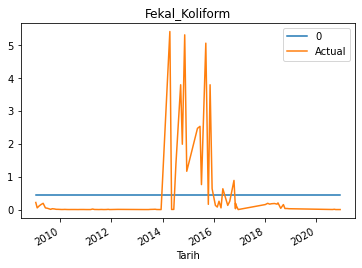

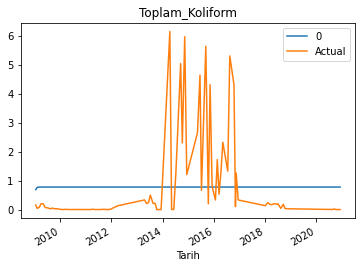

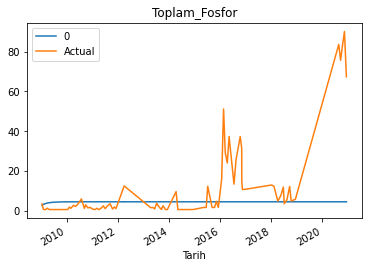

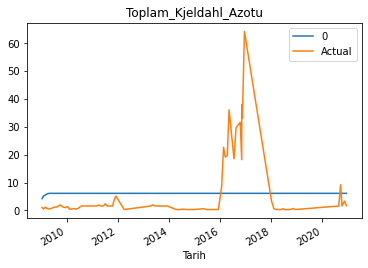

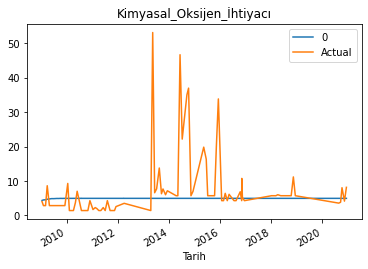

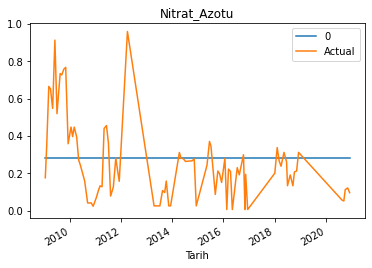

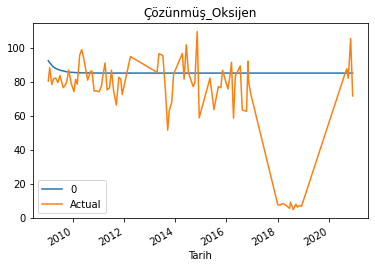

In [38]:
for i in range(7):
    pred_list[i].plot(legend = True, label = 'Predicted')
    test_inv[i].plot(legend = True, label = 'Actual')
    plt.title(akarsu_cols[i])
    plt.savefig('../ml_images/arima/arima_'+akarsu_cols[i]+'.png')